# I - Introduction

# II - Prepare required frameworks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
import lightgbm as lgbm
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
import joblib
from sklearn.metrics import roc_curve, auc

In [2]:
from sklearn.tree import DecisionTreeClassifier as DTC


In [3]:
import warnings

# Ẩn tất cả các cảnh báo
warnings.filterwarnings('ignore')

In [4]:
# from sklearnex import patch_sklearn

In [5]:
# patch_sklearn()

# III - Prepare dataset

# 1. Load dataset

In [6]:
dataset = pd.read_csv('./dataset/Dry_Bean_Dataset.csv')

In [7]:
# dataset.info()

In [8]:
# dataset.duplicated().sum()

In [9]:
dataset = dataset.set_index('Bean ID')

In [10]:
dataset.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [11]:
features = dataset.columns[:-1]
target = dataset.columns[-1]

In [12]:
# x.describe()

In [13]:
x = dataset[features]
y = dataset[target]

In [14]:
scaler = StandardScaler()
encoder = LabelEncoder()

In [15]:
# dataset['Class'] = pd.DataFrame(encoder.fit_transform(dataset['Class']), columns=['Class'])

In [16]:
pd.DataFrame(encoder.fit_transform(dataset['Class']), columns=['Class']).value_counts()

Class
3        3546
6        2636
5        2027
4        1928
2        1630
0        1322
1         522
Name: count, dtype: int64

In [17]:
# dataset['Class'].value_counts()

In [18]:
def prepare_data(dataset, features, target, scaler, encoder):
    x = dataset[features]
    y = dataset[target]
    # y_encoded = encoder.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test, y_train, y_test

In [19]:
x_train, x_test, y_train, y_test = prepare_data(dataset, features, target, scaler, encoder)

# Training models

In [20]:
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

# x_train, x_test, y_train, y_test = prepare_data(dataset, features, target, scaler, encoder)

# # Không gian tìm kiếm cho SVM
# space = {
#     'C': hp.loguniform('C', -4, 2),
#     'gamma': hp.loguniform('gamma', -4, -2),
#     'kernel': hp.choice('kernel', ['rbf', 'linear'])
# }

# # Định nghĩa hàm mục tiêu
# def objective(params):
#     model = SVC(**params)
#     score = cross_val_score(model, x_train, y_train, cv=5, n_jobs=-1)
#     accuracy = score.mean()
#     return -accuracy

# # Khởi tạo Trials để lưu trữ kết quả
# trials = Trials()

# # Thực hiện tìm kiếm hyperparameters
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# # Chuyển đổi kết quả tốt nhất
# best['kernel'] = ['rbf', 'linear'][best['kernel']]

# # In ra kết quả tốt nhất
# print(f"Best parameters: {best}")

# # Đánh giá mô hình trên tập kiểm tra
# best_model = SVC(**best)
# best_model.fit(x_train, y_train)
# test_score = best_model.score(x_test, y_test)
# print(f"Test set score: {test_score}")


In [21]:
def hyperopt_search(space, model, x_train, y_train, x_test, y_test, algo=tpe.suggest, max_evals=100, categorical_params={}, trials=None, integer_params=[]):
    def objective(params, model=model, x_train=x_train, y_train=y_train, integer_params=integer_params):
        for key in integer_params:
            if key in params:
                params[key] = int(params[key])
        model = model(**params)
        
        score = cross_val_score(model, x_train, y_train, cv=5, n_jobs=-1)
        accuracy = score.mean()
        return -accuracy
    
    if trials is None:
        trials = Trials()
    
    best = fmin(fn=objective, space=space, algo=algo, max_evals=max_evals, trials=trials)
    
    for param, idx in categorical_params.items():
        best[param] = idx[best[param]]
        
    for key in integer_params:
        if key in best:
            best[key] = best[key].astype(int)
    
    if "probability" in space and space['probability'] == True:
        best['probability'] = True
    
    best_model = model(**best)
    best_model.fit(x_train, y_train)
    test_score = best_model.score(x_test, y_test)
    print(f"Test set score: {test_score}")
    return best_model, best


In [22]:
### SVC

space = {
    'C': hp.loguniform('C', -2, 4),
    'gamma': hp.loguniform('gamma', -4, -2),
    'kernel': hp.choice('kernel', ['rbf', 'linear']),
    'probability': True
}

category_params = {
    'kernel': ['rbf', 'linear']
}

best_SVC_model, best_SVC_params = hyperopt_search(space, model=SVC, algo=tpe.suggest, max_evals=100, categorical_params=category_params, 
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

100%|██████████| 100/100 [03:56<00:00,  2.36s/trial, best loss: -0.9312095777164471]
Test set score: 0.9305912596401028


In [23]:
print(f"Best parameters: {best_SVC_model.get_params()}")
# print(f"Best parameters: {best_SVC_params}")

Best parameters: {'C': 2.1121327565929136, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0938097360160394, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [49]:
# joblib.dump(best_SVC_model, './models/best_SVC_model.pkl')

['./models/best_SVC_model.pkl']

In [25]:
### Random Forest
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 150, 1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

category_params = {}

int_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

best_RF_model, best_RF_params = hyperopt_search(space, model=RFC, algo=tpe.suggest, max_evals=100, categorical_params=category_params, integer_params=int_params, 
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

100%|██████████| 100/100 [07:58<00:00,  4.78s/trial, best loss: -0.9239533599662216]
Test set score: 0.9192067572530297


In [60]:
# joblib.dump(best_RF_model, './models/best_RF_model.pkl')

['./models/best_RF_model.pkl']

In [27]:
print(f"Best parameters: {best_RF_params}")

Best parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 132}


In [28]:
### KNN
space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'p': hp.choice('p', [1, 2]),
}

category_params = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

int_params = ['n_neighbors']

best_KNN_model, best_KNN_params = hyperopt_search(space, model=KNC, algo=tpe.suggest, max_evals=100, categorical_params=category_params, integer_params=int_params, 
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

100%|██████████| 100/100 [00:17<00:00,  5.76trial/s, best loss: -0.9257907508711367]
Test set score: 0.9166360631656262


In [29]:
print(f"Best parameters: {best_KNN_params}")

Best parameters: {'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}


In [59]:
# joblib.dump(best_KNN_model, './models/best_KNN_model.pkl')

['./models/best_KNN_model.pkl']

In [31]:
### Logistic Regression
space = {
    'C': hp.loguniform('C', -4, 4),
    'penalty': hp.choice('penalty', ['l2']),
}

category_params = {
    'penalty': ['l2']
}

best_LR_model, best_LR_params = hyperopt_search(space, model=LR, algo=tpe.suggest, max_evals=100, categorical_params=category_params, 
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

100%|██████████| 100/100 [00:29<00:00,  3.33trial/s, best loss: -0.9249639249639248]
Test set score: 0.9239809034153507


In [32]:
# print(best_LR_model.get_params())

In [33]:
print(f"Best parameters: {best_LR_params}")

Best parameters: {'C': 1.252882533813261, 'penalty': 'l2'}


In [58]:
# joblib.dump(best_LR_model, './models/best_LR_model.pkl')

['./models/best_LR_model.pkl']

In [35]:
### LightGBM
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 150, 1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'num_leaves': hp.quniform('num_leaves', 10, 100, 1),
    'verbose': -1
}

category_params = {}

int_params = ['n_estimators', 'max_depth', 'num_leaves']

best_LGBM_model, best_LGBM_params = hyperopt_search(space, model=lgbm.LGBMClassifier, algo=tpe.suggest, max_evals=100, categorical_params=category_params, integer_params=int_params, 
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

100%|██████████| 100/100 [04:11<00:00,  2.52s/trial, best loss: -0.9290054678829891]
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 10888, number of used features: 16
[LightGBM] [Info] Start training from score -2.345560
[LightGBM] [Info] Start training from score -3.257546
[LightGBM] [Info] Start training from score -2.126837
[LightGBM] [Info] Start training from score -1.346678
[LightGBM] [Info] Start training from score -1.926446
[LightGBM] [Info] Start training from score -1.917658
[LightGBM] [Info] Start training from score -1.640973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: probability
Test set score: 0

In [36]:
print(f"Best parameters: {best_LGBM_params}")

Best parameters: {'learning_rate': 0.05070313528941705, 'max_depth': 16, 'n_estimators': 106, 'num_leaves': 10, 'probability': True}


In [50]:
# joblib.dump(best_LGBM_model, "./models/best_LGBM_model.pkl")

['./models/best_LGBM_model.pkl']

In [38]:
# ---
### Decision Tree
space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.quniform('max_depth', 5, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

category_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

int_params = ['max_depth', 'min_samples_split', 'min_samples_leaf']

best_DT_model, best_DT_params = hyperopt_search(space, model=DTC, algo=tpe.suggest, max_evals=100, categorical_params=category_params, integer_params=int_params, 
                                                  x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

100%|██████████| 100/100 [00:33<00:00,  2.97trial/s, best loss: -0.9123815513467661]
Test set score: 0.9118619170033052


In [56]:
print(f"Best parameters: {best_DT_params}")

Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'best'}


In [57]:
# joblib.dump(best_DT_model, './models/best_DT_model.pkl')

['./models/best_DT_model.pkl']

In [39]:
# def evaluate_model(model, x_test, y_test):
#     report = classification_report(y_test, model.predict(x_test))
#     print("Classification report:\n", report)
#     cv_score = cross_val_score(model, x_test, y_test, cv=5, n_jobs=-1).mean()
#     print(f"Cross val score ==>>>>: {cv_score}")
    
#     # Dự đoán xác suất trên tập kiểm tra
#     y_prob = model.predict_proba(x_test)[:, 1]

#     # Tính toán giá trị FPR và TPR cho các ngưỡng khác nhau
#     fpr, tpr, thresholds = roc_curve(y_test, y_prob)

#     # Tính toán diện tích dưới đường cong (AUC)
#     roc_auc = auc(fpr, tpr)

#     # Vẽ đường cong ROC
#     plt.figure()
#     plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic')
#     plt.legend(loc='lower right')
#     plt.show()

In [40]:
from sklearn.preprocessing import label_binarize


In [41]:
# Hàm vẽ ROC curve cho mô hình
def evaluate_model(model, x_test, y_test, classes):
    report = classification_report(y_test, model.predict(x_test), digits=4)
    print("Classification report:\n", report)
    cv_score = cross_val_score(model, x_test, y_test, cv=5, n_jobs=-1).mean()
    print(f"Cross val score ==>>>>: {cv_score}")
    
    
    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # For each class
    for i in range(len(classes)):
        # Compute ROC curve and ROC area
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(x_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), model.predict_proba(x_test).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


Classification report:
               precision    recall  f1-score   support

    BARBUNYA     0.9731    0.9068    0.9388       279
      BOMBAY     1.0000    1.0000    1.0000       103
        CALI     0.9467    0.9639    0.9552       332
    DERMASON     0.9160    0.9314    0.9236       714
       HOROZ     0.9589    0.9561    0.9575       342
       SEKER     0.9639    0.9391    0.9514       427
        SIRA     0.8627    0.8840    0.8732       526

    accuracy                         0.9306      2723
   macro avg     0.9459    0.9402    0.9428      2723
weighted avg     0.9314    0.9306    0.9308      2723

Cross val score ==>>>>: 0.9228750674581759


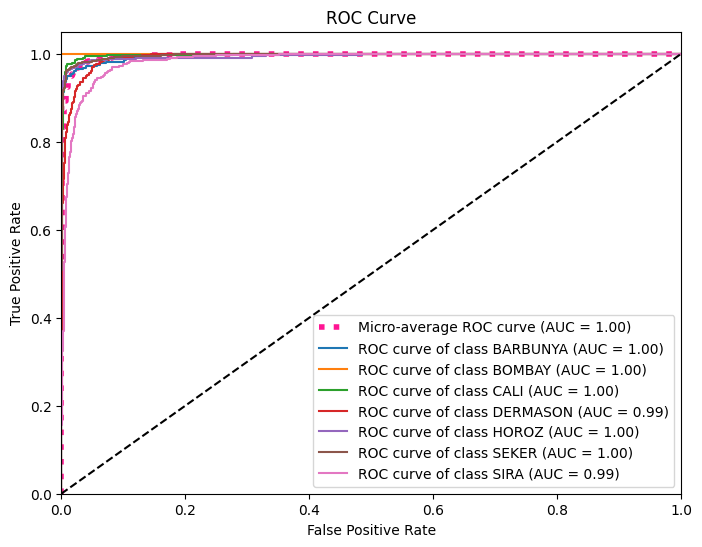

In [42]:
## SVC
evaluate_model(best_SVC_model, x_test, y_test, classes=encoder.classes_)

Classification report:
               precision    recall  f1-score   support

    BARBUNYA     0.9538    0.8889    0.9202       279
      BOMBAY     1.0000    1.0000    1.0000       103
        CALI     0.9233    0.9428    0.9329       332
    DERMASON     0.9009    0.9300    0.9152       714
       HOROZ     0.9395    0.9532    0.9463       342
       SEKER     0.9570    0.9391    0.9480       427
        SIRA     0.8649    0.8517    0.8582       526

    accuracy                         0.9192      2723
   macro avg     0.9342    0.9294    0.9316      2723
weighted avg     0.9195    0.9192    0.9191      2723

Cross val score ==>>>>: 0.9188417431192661


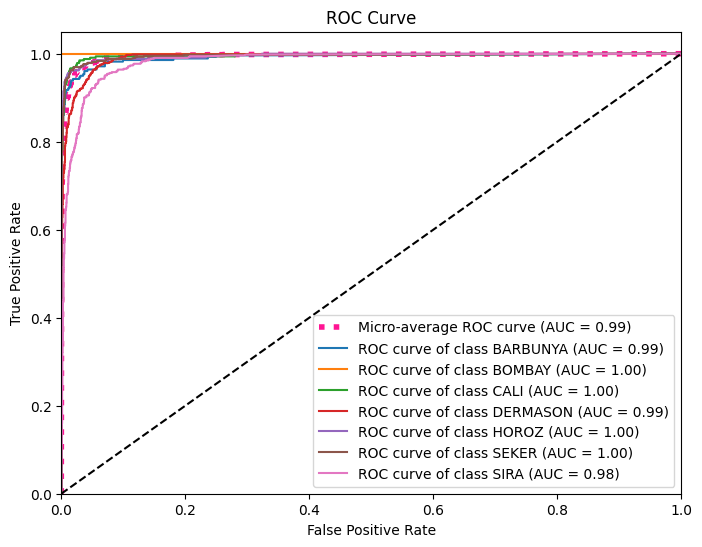

In [51]:
### Random Forest
evaluate_model(best_RF_model, x_test, y_test, classes=encoder.classes_)

Classification report:
               precision    recall  f1-score   support

    BARBUNYA     0.9562    0.8602    0.9057       279
      BOMBAY     1.0000    1.0000    1.0000       103
        CALI     0.9162    0.9548    0.9351       332
    DERMASON     0.9046    0.9160    0.9102       714
       HOROZ     0.9587    0.9503    0.9545       342
       SEKER     0.9590    0.9321    0.9454       427
        SIRA     0.8407    0.8726    0.8563       526

    accuracy                         0.9166      2723
   macro avg     0.9336    0.9266    0.9296      2723
weighted avg     0.9179    0.9166    0.9168      2723

Cross val score ==>>>>: 0.9177394765245548


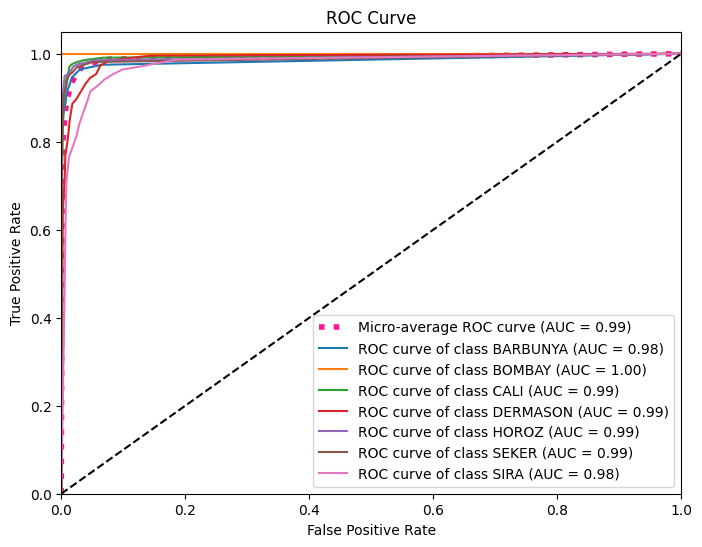

In [52]:
### KNN
evaluate_model(best_KNN_model, x_test, y_test, classes=encoder.classes_)

Classification report:
               precision    recall  f1-score   support

    BARBUNYA     0.9438    0.9032    0.9231       279
      BOMBAY     1.0000    1.0000    1.0000       103
        CALI     0.9403    0.9488    0.9445       332
    DERMASON     0.9194    0.9272    0.9233       714
       HOROZ     0.9393    0.9503    0.9448       342
       SEKER     0.9662    0.9368    0.9512       427
        SIRA     0.8532    0.8726    0.8628       526

    accuracy                         0.9240      2723
   macro avg     0.9375    0.9341    0.9357      2723
weighted avg     0.9246    0.9240    0.9242      2723

Cross val score ==>>>>: 0.9181050998381004


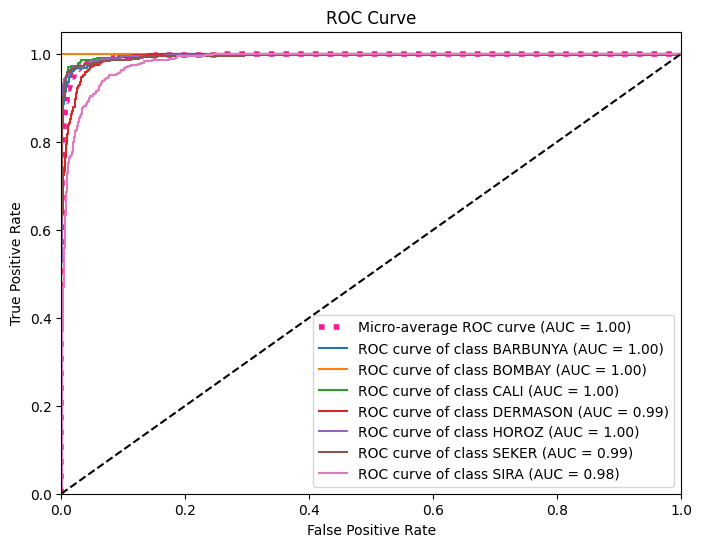

In [53]:
### Logistic Regression
evaluate_model(best_LR_model, x_test, y_test, classes=encoder.classes_)

[LightGBM] [Warning] Unknown parameter: probability
Classification report:
               precision    recall  f1-score   support

    BARBUNYA     0.9656    0.9068    0.9353       279
      BOMBAY     1.0000    1.0000    1.0000       103
        CALI     0.9463    0.9548    0.9505       332
    DERMASON     0.9068    0.9272    0.9169       714
       HOROZ     0.9618    0.9561    0.9589       342
       SEKER     0.9568    0.9344    0.9455       427
        SIRA     0.8545    0.8707    0.8625       526

    accuracy                         0.9251      2723
   macro avg     0.9417    0.9357    0.9385      2723
weighted avg     0.9258    0.9251    0.9253      2723

Cross val score ==>>>>: 0.9173698057204535
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unk

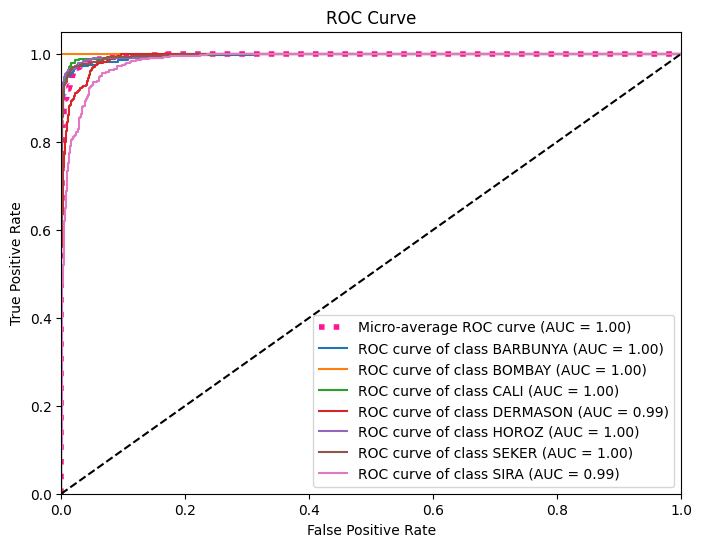

In [54]:
### LightGBM
evaluate_model(best_LGBM_model, x_test, y_test, classes=encoder.classes_)

Classification report:
               precision    recall  f1-score   support

    BARBUNYA     0.9470    0.8961    0.9208       279
      BOMBAY     1.0000    1.0000    1.0000       103
        CALI     0.9284    0.9367    0.9325       332
    DERMASON     0.8984    0.9160    0.9071       714
       HOROZ     0.9382    0.9327    0.9355       342
       SEKER     0.9452    0.9297    0.9374       427
        SIRA     0.8424    0.8536    0.8480       526

    accuracy                         0.9119      2723
   macro avg     0.9285    0.9236    0.9259      2723
weighted avg     0.9124    0.9119    0.9120      2723

Cross val score ==>>>>: 0.8876214247166757


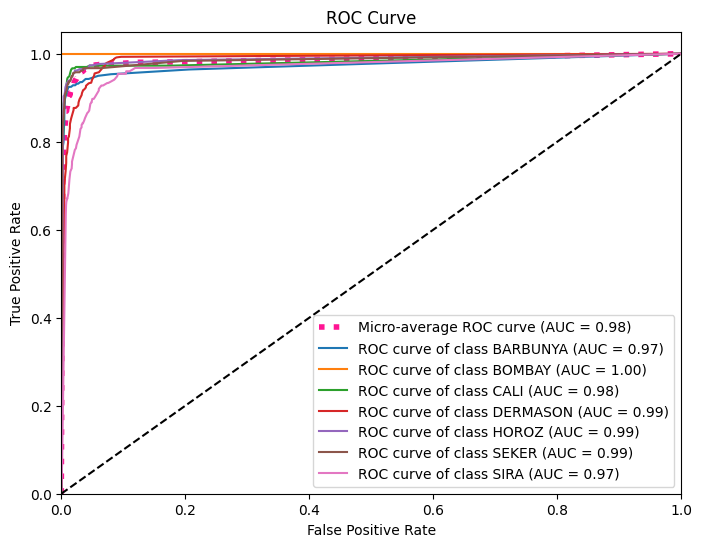

In [55]:
### Decision Tree
evaluate_model(best_DT_model, x_test, y_test, classes=encoder.classes_)

# Stacked Generalization

In [43]:
from sklearn.ensemble import StackingClassifier


In [44]:
# Khởi tạo Stacking với các mô hình con
stacking_model = StackingClassifier(
    estimators=[
        # ('knn', best_KNN_model),
        # ('log_reg', best_LR_model),
        ('svc', best_SVC_model),
        ('tree', best_DT_model),
        ('lgbm', best_LGBM_model),
        ('rf', best_RF_model)
    ],
    final_estimator=best_SVC_model,
    cv=5
)

In [45]:
# Huấn luyện mô hình Stacking
stacking_model.fit(x_train, y_train)

# Dự đoán và đánh giá
y_pred = stacking_model.predict(x_test)
# print(classification_report(y_test, y_pred))
stacking_model.score(x_test, y_test)

# In kết quả
# print(f'Accuracy of Stacking Classifier: {acc:.2f}')

[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 10888, number of used features: 16
[LightGBM] [Info] Start training from score -2.345560
[LightGBM] [Info] Start training from score -3.257546
[LightGBM] [Info] Start training from score -2.126837
[LightGBM] [Info] Start training from score -1.346678
[LightGBM] [Info] Start training from score -1.926446
[LightGBM] [Info] Start training from score -1.917658
[LightGBM] [Info] Start training from score -1.640973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Warning] Unknown parameter: probability
[LightGBM] [Info] Auto-choosing col-wise multi-thr

0.9272860815277267

In [46]:
# joblib.dump(stacking_model, './models/stacking_model.pkl')

In [47]:
stacking_model.get_params()

{'cv': 5,
 'estimators': [('svc',
   SVC(C=2.1121327565929136, gamma=0.0938097360160394, probability=True)),
  ('tree',
   DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=10,
                          min_samples_split=10)),
  ('lgbm',
   LGBMClassifier(learning_rate=0.05070313528941705, max_depth=16,
                  n_estimators=106, num_leaves=10, probability=True)),
  ('rf',
   RandomForestClassifier(max_depth=18, min_samples_split=3, n_estimators=132))],
 'final_estimator__C': 2.1121327565929136,
 'final_estimator__break_ties': False,
 'final_estimator__cache_size': 200,
 'final_estimator__class_weight': None,
 'final_estimator__coef0': 0.0,
 'final_estimator__decision_function_shape': 'ovr',
 'final_estimator__degree': 3,
 'final_estimator__gamma': 0.0938097360160394,
 'final_estimator__kernel': 'rbf',
 'final_estimator__max_iter': -1,
 'final_estimator__probability': True,
 'final_estimator__random_state': None,
 'final_estimator__shrinking': True,
 'f

# -------------------------------------------

In [48]:
----

SyntaxError: invalid syntax (2133496677.py, line 1)

In [ ]:
models = {
    "KNeighbors": KNC(),
    "LogisticRegression": LR(),
    "RandomForest": RFC(),
    "SVC": SVC(),
    # "GradientBoosting": GBC(),
    "LightGBM": lgbm.LGBMClassifier(verbose=-1)
}

def get_scores(models, xtrain, ytrain, xtest, ytest):
    for name, model in models.items():
        print(f"-----> {name}")
        model.fit(xtrain, ytrain)
        ypred = model.predict(xtest)
        model.score(xtest, ytest)
        print("---> Model score: ", model.score(xtest, ytest))
        reports = classification_report(ytest, ypred)
        print("---> Classification_reports: \n", reports)
        
        # scores = np.mean(cross_val_score(model, xtrain, ytrain, cv=5))
        # print("---> Cross-validation scores: \n", scores)
        print("============================================\n")

In [ ]:
get_scores(models, x_train, y_train, x_test, y_test)

# EDA

# Các thuộc tính
Area (A)	Diện tích:	Diện tích vùng của hạt đậu và số pixel nằm trong ranh giới của nó.

Perimeter (P)	Chu vi:	Chu vi của hạt đậu được định nghĩa là độ dài của đường viền.

Major axis length (L)	Độ dài trục chính:	Khoảng cách giữa hai đầu của đường thẳng dài nhất có thể vẽ trên hạt đậu.

Minor axis length (l)	Độ dài trục phụ:	Đường thẳng dài nhất có thể vẽ trên hạt đậu theo hướng vuông góc với trục chính.

Aspect ratio (K)	Tỷ lệ dài rộng:	Xác định mối quan hệ giữa L và l.

Eccentricity (Ec)	Độ lệch tâm:	Độ lệch tâm của hình elip có cùng các mô men như vùng hạt đậu.

Convex area (C)	Diện tích lồi:	Số pixel trong đa giác lồi nhỏ nhất có thể chứa diện tích của hạt đậu.

Equivalent diameter (Ed)	Đường kính tương đương:	Đường kính của một hình tròn có cùng diện tích với diện tích của hạt đậu.

Extent (Ex)	Độ bao phủ:	Tỷ lệ giữa số pixel trong khung bao và diện tích của hạt đậu.

Solidity (S)	Độ đặc:	Còn được gọi là độ lồi. Tỷ lệ giữa số pixel trong vỏ lồi và số pixel tìm thấy trong hạt đậu.

Roundness (R)	Độ tròn:	Được tính toán bằng công thức: (4piA)/(P^2)

Compactness (CO)	Độ gọn:	Đo độ tròn của một vật thể: Ed/L

ShapeFactor1 (SF1)	Hệ số hình dạng 1:	Tham số hình dạng bổ sung.

ShapeFactor2 (SF2)	Hệ số hình dạng 2:	Tham số hình dạng bổ sung.

ShapeFactor3 (SF3)	Hệ số hình dạng 3:	Tham số hình dạng bổ sung.

ShapeFactor4 (SF4)	Hệ số hình dạng 4:	Tham số hình dạng bổ sung.

Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)	Lớp	Thuộc tính này phân loại hạt đậu thành các loại khác nhau: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz và Sira.


In [ ]:
dataset['Class'].value_counts().plot(kind='bar', xlabel='Types of bean', ylabel='Count')

### Drop outliner

In [ ]:
data_heads = x.columns
data_heads

In [ ]:
# # Biều đồ hist thêm đường trung vị
# fig, axes = plt.subplots(4,4, figsize = (24,24))
# for i, axe in enumerate(axes.flatten()):
#     sns.histplot(data = x[data_heads[i]], ax = axe)
#     median = x[data_heads[i]].median()
#     axe.set_title(f'{data_heads[i]} (Median = {median:0.1f})')
#     axe.axvline(median, color='red', lw=2, alpha=1)

In [ ]:
# # Biều đồ Boxplot để xem nhiễu
# fig, axes = plt.subplots(4, 4, figsize=(24,24))
# for i,axe in enumerate(axes.flatten()):
#     sns.boxplot(data = x[data_heads[i]], ax = axe)
#     axe.set_title(f'{data_heads[i]}')
# plt.tight_layout()

In [ ]:
# fig, axes = plt.subplots(8, 2, figsize=(24,48))
# for feature, ax in zip(x.columns, axes.flatten()):
#     sns.violinplot(data = dataset, x = 'Class', y = feature, ax = ax, inner="quartile" )
#     ax.set(xlabel = None)
#     ax.set_title(f'Phân bố {feature} từng loại')

In [ ]:
def drop_outliers(dataset, features):
    # Tính toán Z-score cho mỗi điểm dữ liệu
    z_scores = stats.zscore(dataset[features])

    # Xác định ngưỡng cho Z-score
    threshold = 3

    # Loại bỏ các outlier
    dataset_cleaned = dataset.loc[(z_scores < threshold).all(axis=1)]

    # In ra số lượng outlier đã loại bỏ
    outliers_removed = dataset.shape[0] - dataset_cleaned.shape[0]
    print("Số lượng outlier đã loại bỏ:", outliers_removed)
    return dataset_cleaned

In [ ]:
dataset_cleaned = drop_outliers(dataset, features)
x_train, x_test, y_train, y_test = prepare_data(dataset_cleaned, features, target, scaler, encoder)
# get_scores(models, x_train, y_train, x_test, y_test)

### Drop large corr

In [ ]:
# # correlation matrix
# plt.figure(figsize=(20,20))
# sns.heatmap(x.corr(),annot = True, cmap = 'viridis_r', fmt = '.2f');

In [ ]:
def drop_corr(dataset, features):
    # Đọc dữ liệu từ file CSV hoặc tạo ma trận tương quan từ dữ liệu hiện có
    corr_matrix = dataset[features].corr().abs()

    # Chọn ngưỡng tương quan
    threshold = 0.8

    # Tạo một bản sao của ma trận tương quan
    mask = corr_matrix.copy()

    # Thiết lập giá trị True cho các ô phía trên đường chéo chính
    # mask[np.triu_indices_from(mask.values)] = 0

    for i in range(len(mask.columns)):
        for j in range(i + 1):
            mask.iloc[i,j] = 0

    # print(mask)
    # Loại bỏ các biến dựa trên ngưỡng tương quan
    drop_cols = [column for column in mask.columns if any(mask[column] > threshold)]

    # Loại bỏ các cột từ DataFrame
    dataset_filtered = dataset.drop(drop_cols, axis=1)
    return dataset_filtered

In [ ]:
dataset_filtered = drop_corr(dataset_cleaned, features)

In [ ]:
x_train, x_test, y_train, y_test = prepare_data(dataset_filtered, dataset_filtered.columns[:-1], dataset_filtered.columns[-1], scaler, encoder)

In [ ]:
# get_scores(models, x_train, y_train, x_test, y_test)

In [ ]:
# Strongly_corr_features = dataset[["Area","Perimeter","AspectRation","Eccentricity","roundness","Compactness","Class"]]
# Strongly_corr_features.head()
# sns.set_theme(style="whitegrid")
# sns.pairplot(Strongly_corr_features, hue="Class")

In [ ]:
dataset.columns

In [ ]:
mi_scores = mutual_info_classif(x, y, random_state = 31)
mi_scores_df = pd.DataFrame({'Feature': x.columns, 'MI Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False).reset_index(drop=True)

# plt.figure(figsize=(20,10))
# sns.barplot(x='MI Score', y='Feature', data=mi_scores_df) 
# plt.xlabel('Mutual Information Score')
# # plt.ylabel('Feature')
# plt.title('Mutual Information Scores for Each Feature')
# # plt.gca().invert_yaxis() # sắp xếp lại theo giảm dần
# plt.show()

### Drop large corr and outliner

In [ ]:
data = drop_corr(dataset_cleaned, features)
x_train, x_test, y_train, y_test = prepare_data(data, data.columns[:-1], data.columns[-1], scaler, encoder)
# get_scores(models, x_train, y_train, x_test, y_test)

# * Data augmentation

## ** SMOTE

In [ ]:
! pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
x_train, x_test, y_train, y_test = prepare_data(dataset, dataset.columns[:-1], dataset.columns[-1], scaler, encoder)

In [ ]:
x_train.shape

In [ ]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# for i in range(4):
#     x_train_resampled, y_train_resampled = smote.fit_resample(x_train_resampled, y_train_resampled)
print(x_train_resampled.shape)    
print(y_train_resampled.shape)

# get_scores(models, x_train_resampled, y_train_resampled, x_test, y_test)

In [ ]:
pd.DataFrame(y_train).value_counts()

## ** Feature perturbation

In [ ]:
x = dataset[features]
y = dataset[target]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [ ]:
x_train.shape

In [ ]:
traindf = pd.DataFrame(x_train, columns=features)
traindf['Class'] = y_train

In [ ]:
countdf = traindf['Class'].value_counts()
for i in countdf.index:
    countdf[i] = 3500 / countdf[i]
countdf

In [ ]:
# Hàm để thêm nhiễu Gaussian

df1 = traindf.loc[traindf['Class'] == 'DERMASON']
df2 = traindf.loc[traindf['Class'] == 'SIRA']
df3 = traindf.loc[traindf['Class'] == 'SEKER']
df4 = traindf.loc[traindf['Class'] == 'HOROZ']
df5 = traindf.loc[traindf['Class'] == 'CALI']
df6 = traindf.loc[traindf['Class'] == 'BARBUNYA']
df7 = traindf.loc[traindf['Class'] == 'BOMBAY']



In [ ]:
# Hàm để thêm nhiễu Gaussian
def add_gaussian_noise(series, mean=0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, series.shape)
    return series + noise

def add_noise(df):
    for column in df.columns:
        if column != 'Class':
            df[column] = add_gaussian_noise(df[column])
    return df

In [ ]:
for i in countdf.index:
    if i == 'DERMASON':
        cp = df1.copy()
        for j in range(round(countdf[i]) - 2):
            df1 = pd.concat([df1, add_noise(cp)])
    elif i == 'SIRA':
        cp = df2.copy()
        for j in range(round(countdf[i]) - 2):
            df2 = pd.concat([df2, add_noise(cp)])
    elif i == 'SEKER':
        cp = df3.copy()
        for j in range(round(countdf[i]) - 2):
            df3 = pd.concat([df3, add_noise(cp)])
    elif i == 'HOROZ':
        cp = df4.copy()
        for j in range(round(countdf[i]) - 2):
            df4 = pd.concat([df4, add_noise(cp)])
    elif i == 'CALI':
        cp = df5.copy()
        for j in range(round(countdf[i]) - 2):
            df5 = pd.concat([df5, add_noise(cp)])
    elif i == 'BARBUNYA':
        cp = df6.copy()
        for j in range(round(countdf[i]) - 2):
            df6 = pd.concat([df6, add_noise(cp)])
    elif i == 'BOMBAY':
        cp = df7.copy()
        for j in range(round(countdf[i]) - 2):
            df7 = pd.concat([df7, add_noise(cp)])


In [ ]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7])

In [ ]:
df.shape

In [ ]:
df['Class'].value_counts()

In [ ]:
fp_data = pd.concat([traindf, df], axis=0)

In [ ]:
fp_data.shape

In [ ]:
fp_data['Class'].value_counts()

In [ ]:
# fp_x_train, fp_x_test, fp_y_train, fp_y_test = prepare_data(fp_data, fp_data.columns[:-1], fp_data.columns[-1], scaler, encoder)
x_fp_train = fp_data[features]
y_fp_train = fp_data[target]

In [ ]:
features

In [ ]:
target

In [ ]:
# get_scores(models, x_fp_train, y_fp_train, x_test, y_test)

## ** Synthetic data generation

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
dataset.head()

In [ ]:

# Chuyển đổi các đặc trưng phân loại sang số (encoding)
df_encoded = pd.get_dummies(dataset, columns=['Class'])

# Chuẩn bị dữ liệu cho mô hình GMM
X = df_encoded.values

# Khởi tạo và huấn luyện mô hình Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

# Sinh dữ liệu mới từ mô hình GMM
num_samples = 10000  # Số lượng mẫu mới cần tạo
X_synthetic = gmm.sample(num_samples)[0]

# Chuyển đổi dữ liệu sinh ngược lại thành DataFrame
df_synthetic = pd.DataFrame(X_synthetic, columns=df_encoded.columns)

# Đảo ngược quá trình encoding để có các đặc trưng phân loại
for class_label in dataset['Class'].unique():
    df_synthetic[class_label] = (dataset['Class'] == class_label).astype(int)

# Thêm nhãn giả lập (hoặc có thể sử dụng một mô hình để dự đoán nhãn)
df_synthetic['Label'] = np.random.choice(dataset['Class'].unique(), size=num_samples)

# In ra dữ liệu mới
print("Dữ liệu sau khi sinh từ GMM:")
df_synthetic.head()